In [1]:
import requests
import json
import os
from WSMethods import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import vxi11
import math


In [2]:
#光スペアナ接続
instr =  vxi11.Instrument("169.254.6.1")
print(instr.ask("*IDN?"))



In [2]:
#Waveshaper接続
# Define device IP
ip = '169.254.6.8'
# Get device info 
result = requests.get('http://' + ip + '/waveshaper/devinfo').json()

#print(result)
# Set frequency variables from device info
s = result['startfreq']
e = result['stopfreq']

In [117]:
def getOSA(trace_name):
    c = 299792458

    #光スペアナのx軸（波長）取得
    wavelength = instr.ask(':TRACe:X? '+trace_name)
    wavelength = wavelength.split(',')
    wavelength = [float(ii) for ii in wavelength]
    #print(wavelength[0])
    wavelength = np.array(wavelength)#m

    freq = [c/ii/10**12 for ii in wavelength]#THz
    #print(freq[0])
    #print(freq[-1])

    #光スペアナのy軸（dBm/nm）取得
    nrf = instr.ask(':CALCULATE:MATH:TRF:PNBW:BAND?')#正規化帯域幅
    #print(nrf)#0.1という数値が出てくるものの何のため？

    data = instr.ask(':TRACe:Y:PDENsity? '+trace_name+',1nm')
    data = data.split(',')
    data = [float(ii) for ii in data]
    data = np.array(data)

    optFreq = freq
    optSpectrum = data

    optFreq = optFreq[::-1]
    optSpectrum = optSpectrum[::-1]

    optFreq = np.hstack((s-0.05,optFreq))
    optFreq = np.hstack((optFreq,e+0.05))
    optSpectrum = np.hstack((optSpectrum[0],optSpectrum))
    optSpectrum = np.hstack((optSpectrum,optSpectrum[-1]))
    
    return optFreq,optSpectrum

0.0004989294222355056


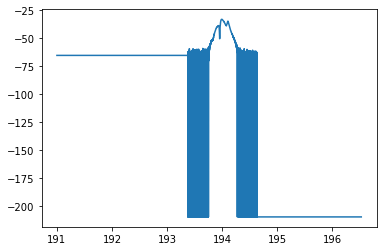

In [118]:
optFreq,optSpectrum = getOSA('TRA')
plt.plot(optFreq, optSpectrum)
print(optFreq[2] - optFreq[1])

In [62]:
#1.76GHz
print(len(optFreq))
mod_freq = optFreq[1:-1]
print(len(mod_freq))
mod_freq = mod_freq+0.00176
mod_optFreq = np.hstack((optFreq[0],mod_freq))
mod_optFreq = np.hstack((mod_optFreq,optFreq[-1]))

2503
2501


0.0004989294222355056


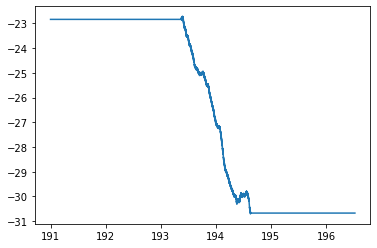

In [119]:
optFreq_main,optSpectrum_main = getOSA('TRE')
plt.plot(optFreq_main, optSpectrum_main)
print(optFreq_main[2] - optFreq_main[1])

In [17]:
targetAttn = optSpectrum_main-optSpectrum
minAttn = min(targetAttn)

new_targetAttn = targetAttn
# new_targetAttn = np.zeros(len(targetAttn))
# for ii in range(len(targetAttn)):
#     if targetAttn[ii] > minAttn+15:
#         new_targetAttn[ii] = 60
#     else:
#         new_targetAttn[ii] = targetAttn[ii]


-30.704674


<ipython-input-227-317e12d53a9d>:6: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(amp_gauss*np.exp(-((freq-center_gauss)/width_gauss)**2))


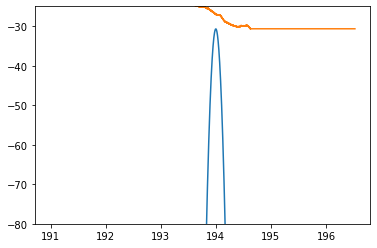

In [227]:
center_gauss = 194#THz
width_gauss = 0.05#THz
amp_gauss = 10**(min(optSpectrum_main)/10)
print(10*np.log10(amp_gauss))
def optSpectrum_gauss_log(freq):
    return 10*np.log10(amp_gauss*np.exp(-((freq-center_gauss)/width_gauss)**2))

gauss = optSpectrum_gauss_log(optFreq)
plt.plot(optFreq,gauss)
plt.plot(optFreq,optSpectrum_main)
plt.ylim([-80,-25])
plt.show()

In [6]:
targetAttn = optSpectrum_main-gauss
minAttn = min(targetAttn)

new_targetAttn = targetAttn

NameError: name 'optSpectrum_main' is not defined

In [3]:
print(s)
print(e)
wsFreq = np.arange(s, e + 0.001, 0.001)
print(wsFreq)

191.05
196.475
[191.05  191.051 191.052 ... 196.473 196.474 196.475]


In [230]:
#f = interp1d(optFreq, optSpectrum, kind='linear')
f = interp1d(mod_optFreq, new_targetAttn, kind='linear')

optSpectrumInterp = f(wsFreq)
maxPower = max(optSpectrumInterp)
normPower = -4
calb = 0 # yokuwakaranai


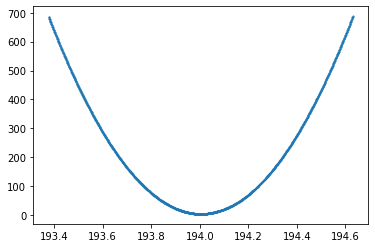

In [231]:
#plt.scatter(wsFreq, ((optSpectrumInterp - maxPower) - normPower)  - calb,s=1)
plt.scatter(wsFreq, optSpectrumInterp,s=1)

In [4]:
#wsAttn = (optSpectrumInterp - maxPower) - normPower - calb
#test = [min(ii,-60) for ii in optSpectrumInterp]
wsAttn = optSpectrumInterp
# wsPhase = np.random.rand(wsFreq.shape[0])
# wsPhase = wsPhase*2*math.pi
wsPhase = np.zeros(wsFreq.shape)
#print(wsPhase)
dispersion = 3.4*10**3
wsPhase = [dispersion*(1-f/194)**2 for f in wsFreq]
wsPhase = np.array(wsPhase)
#print(wsPhase)
wsPort = np.ones(wsFreq.shape)
# Upload profile using created data
r = uploadProfile(ip, wsFreq, wsAttn, wsPhase, wsPort)

NameError: name 'optSpectrumInterp' is not defined

In [233]:
#np.savetxt("test.wsp", )
instr.close()

<ipython-input-17-9e41cb38fec0>:6: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(np.exp(-((freq-freq1)/width_gauss)**2))


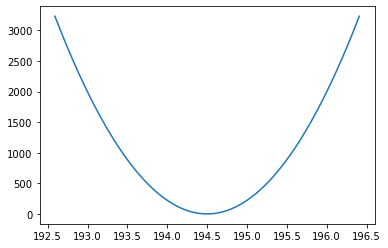

In [17]:
# single band pass filter 
freq1 = 194.5
width_gauss = 0.07

def optSpectrum_single_gauss_log(freq, freq1, width_gauss):
    return 10*np.log10(np.exp(-((freq-freq1)/width_gauss)**2))

single_gauss_filter = optSpectrum_single_gauss_log(wsFreq, freq1, width_gauss)

plt.plot(wsFreq,-single_gauss_filter)

plt.show()

In [23]:
# Upload profile using created data
#wsPhase = np.zeros(wsFreq.shape)
#dispersion = 3.4*10**5
dispersion = 3.4*10**2
wsPhase = [dispersion*(1-f/194)**2 for f in wsFreq]
wsPhase = np.array(wsPhase)

wsPort = np.ones(wsFreq.shape)
r = uploadProfile(ip, wsFreq, np.array(-single_gauss_filter), wsPhase, wsPort)

<ipython-input-27-b3c7526da69a>:7: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(np.exp(-((freq-freq1)/width_gauss)**2) + np.exp(-((freq-freq2)/width_gauss)**2))


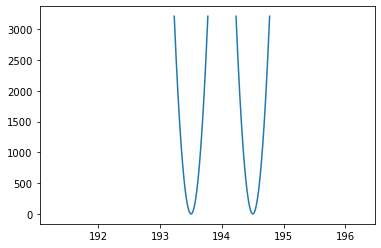

In [27]:
# double band pass filter 
freq1 = 193.5
freq2 = 194.5
width_gauss = 0.01

def optSpectrum_double_gauss_log(freq, freq1, freq2, width_gauss):
    return 10*np.log10(np.exp(-((freq-freq1)/width_gauss)**2) + np.exp(-((freq-freq2)/width_gauss)**2))

double_gauss_filter = optSpectrum_double_gauss_log(wsFreq, freq1, freq2, width_gauss)

plt.plot(wsFreq,-double_gauss_filter)
plt.xlim([191.05,196.47])
plt.show()

In [20]:
# Upload profile using created data
wsPhase = np.zeros(wsFreq.shape)
#print(wsPhase)
wsPort = np.ones(wsFreq.shape)
r = uploadProf

ile(ip, wsFreq, np.array(-double_gauss_filter), wsPhase, wsPort)